<a href="https://colab.research.google.com/github/hansr0518/DQN-with-BO/blob/main/DQN4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
#@title Bayesian optimization을 위한 코드


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Eposide:8 Score: 8, n:0
Eposide:9 Score: 9, n:0
Eposide:10 Score: 10, n:0
Eposide:11 Score: 10, n:0
Eposide:12 Score: 10, n:0
Eposide:13 Score: 9, n:0
Eposide:14 Score: 57, n:26
Eposide:15 Score: 25, n:0
Eposide:16 Score: 47, n:16
Eposide:17 Score: 12, n:0
Eposide:18 Score: 104, n:73
Eposide:19 Score: 14, n:0
Eposide:20 Score: 10, n:0
Eposide:21 Score: 11, n:0
Eposide:22 Score: 10, n:0
Eposide:23 Score: 9, n:0
Eposide:24 Score: 16, n:0
Eposide:25 Score: 9, n:0
Eposide:26 Score: 10, n:0
Eposide:27 Score: 11, n:0
Eposide:28 Score: 9, n:0
Eposide:29 Score: 9, n:0
Eposide:30 Score: 10, n:0
Eposide:31 Score: 18, n:0
Eposide:32 Score: 24, n:0
Eposide:33 Score: 16, n:0
Eposide:34 Score: 20, n:0
Eposide:35 Score: 11, n:0
Eposide:36 Score: 11, n:0
Eposide:37 Score: 10, n:0
Eposide:38 Score: 10, n:0
Eposide:39 Score: 22, n:0
Eposide:40 Score: 12, n:0
Eposide:41 Score: 14, n:0
Eposide:42 Score: 18, n:0
Eposide:43 Score: 10, n:0
Eposide:44 Score: 11, n:0
Eposide

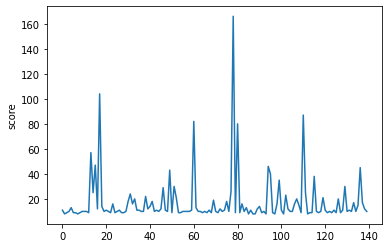

In [ ]:
import gym 
import random 
import math 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

episodes = 140      
batch_size = 32  

 
class DQN:

    def __init__(self):
        self.n=0
        self.model = nn.Sequential(
            nn.Linear(4, 128), # 4개의 state
            nn.ReLU(),  # 기존과 달리 ReLU activation function을 추가하여 성능향상 기대함
            nn.Linear(128, 2) # 2개의 output
        )

        self.steps_done = 0 
        self.memory = deque(maxlen=10000) # buffer limit으로 10000으로 세팅함

        self.pbounds = { # learning rate와 gamma를 최적화 대상으로 함
                'learning_rate': (0.0005, 0.001),
                'gamma': (0.6, 0.98)
            }

        self.bayes_optimizer = BayesianOptimization(
                f=self.train,
                pbounds=self.pbounds,
                random_state=777,
                verbose=2
            )



    def sample_action(self, state):
        eps_threshold = max(0.01, 0.08-0.01*(self.steps_done/200)) 
        self.steps_done += 1 # steps_done
        if random.random() > eps_threshold: # epsilon greedy 수행
            return self.model(state).data.max(1)[1].view(1, 1)
        else:
            return torch.LongTensor([[random.randrange(2)]])

    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))



    def train(self, learning_rate, gamma):

        if len(self.memory) < batch_size: # batch size보다 memory에 쌓인 transition이 적을 때
            self.n=0
            return self.n
 
        batch = random.sample(self.memory, batch_size) 
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)
        
        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma * max_next_q)

        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        loss = F.mse_loss(current_q.squeeze(), expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.n+=1

        return float(sum(max_next_q).detach()) #max_next_q의 sum을 최대화 하는 것이 BO의 target임
        
 
env = gym.make('CartPole-v1') # CartPole environment

score_history = [] 

for num_epi in range(1, episodes+1):
    state = env.reset()
    steps = 0
    agent = DQN()
    while True:
        state = torch.FloatTensor([state]) 
        action = agent.sample_action(state) 
        next_state, reward, done, _ = env.step(action.item())

        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state) 

        agent.train(0.00075 , 0.79) # gamma와 LR의 초기값(boundary로 설정한 min값, max값의 중앙값 사용)
        if num_epi>130: # 130회 이상부터 bayesian optimization 수행

          print("Training starts.")
          agent.bayes_optimizer.maximize(init_points=15, n_iter=10) # 15회 초기값 탐색 후, 그 안에서 10회의 iteration을 돌며 Hyper parameter의 최적값을 search 함

          # Bayesian optimization 값 출력
          print("Best optimization option")
          print(agent.bayes_optimizer.max)

        steps += 1
        state = next_state
          

        if done:
            print("Eposide:{0} Score: {1}, n:{2}".format(num_epi, steps, agent.n))
            score_history.append(steps) 
            break

 

plt.plot(score_history)
plt.ylabel('score')
plt.show()

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-1-55e603205547>:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

Eposide:1 Score: 15, n:0
Eposide:2 Score: 14, n:0
Eposide:3 Score: 20, n:18
Eposide:4 Score: 21, n:39
Eposide:5 Score: 20, n:59
Eposide:6 Score: 14, n:73
Eposide:7 Score: 18, n:91
Eposide:8 Score: 15, n:106
Eposide:9 Score: 19, n:125
Eposide:10 Score: 12, n:137
Eposide:11 Score: 11, n:148
Eposide:12 Score: 9, n:157
Eposide:13 Score: 11, n:168
Eposide:14 Score: 9, n:177
Eposide:15 Score: 8, n:185
Eposide:16 Score: 13, n:198
Eposide:17 Score: 10, n:208
Eposide:18 Score: 9, n:217
Eposide:19 Score: 9, n:226
Eposide:20 Score: 12, n:238
Eposide:21 Score: 9, n:247
Eposide:22 Score: 10, n:257
Eposide:23 Score: 10, n:267
Eposide:24 Score: 10, n:277
Eposide:25 Score: 9, n:286
Eposide:26 Score: 13, n:299
Eposide:27 Score: 8, n:307
Eposide:28 Score: 10, n:317
Eposide:29 Score: 10, n:327
Eposide:30 Score: 9, n:336
Eposide:31 Score: 9, n:345
Eposide:32 Score: 8, n:353
Eposide:33 Score: 13, n:366
Eposide:34 Score: 10, n:376
Eposide:35 Score: 8, n:384
Eposide:36 Score: 10, n:394
Eposide:37 Score: 9, n

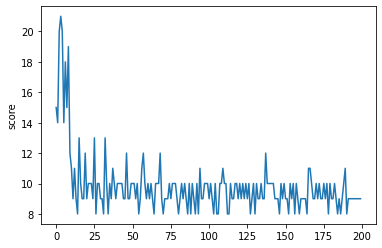

In [ ]:
import gym 
import random 
import math 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt


#Hyper Parameter
episodes = 200   
gamma = 0.98    
learning_rate = 0.0005      
batch_size = 32  

class DQN:

    def __init__(self):
        self.n=0
        self.model = nn.Sequential(
            nn.Linear(4, 128), 
            nn.ReLU(), 
            nn.Linear(128, 2)
        )
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate)
        self.steps_done = 0 
        self.memory = deque(maxlen=10000)


    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))

    def sample_action(self, state):
        eps_threshold = max(0.01, 0.08-0.01*(self.steps_done/200))
        self.steps_done += 1

        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].unsqueeze(1)
        else:
            return torch.LongTensor([[random.randrange(2)]])

    def train(self):
        if len(self.memory) < batch_size:
          self.n=0
          return self.n

        batch = random.sample(self.memory, batch_size) 
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)

        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma * max_next_q)

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.n+=1


env = gym.make('CartPole-v0')
agent = DQN()
score_history = [] 

for num_epi in range(1, episodes+1):
    state = env.reset()
    steps = 0

    while True:
        
        state = torch.FloatTensor([state]) 
        action = agent.sample_action(state) 
        next_state, reward, done, _ = env.step(action.item())

        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state) 
        agent.train()

        state = next_state
        steps += 1

        if done:
            print("Eposide:{0} Score: {1}, n:{2}".format(num_epi, steps, agent.n))
            score_history.append(steps) 
            break

plt.plot(score_history)
plt.ylabel('score')
plt.show()

Eposide:1 Score: 18, n:0
Eposide:2 Score: 25, n:12
Eposide:3 Score: 40, n:52
Eposide:4 Score: 29, n:81
Eposide:5 Score: 21, n:102
Eposide:6 Score: 14, n:116
Eposide:7 Score: 10, n:126
Eposide:8 Score: 10, n:136
Eposide:9 Score: 10, n:146
Eposide:10 Score: 9, n:155
Eposide:11 Score: 8, n:163
Eposide:12 Score: 9, n:172
Eposide:13 Score: 10, n:182
Eposide:14 Score: 10, n:192
Eposide:15 Score: 10, n:202
Eposide:16 Score: 10, n:212
Eposide:17 Score: 9, n:221
Eposide:18 Score: 8, n:229
Eposide:19 Score: 8, n:237
Eposide:20 Score: 10, n:247
Eposide:21 Score: 9, n:256
Eposide:22 Score: 10, n:266
Eposide:23 Score: 10, n:276
Eposide:24 Score: 10, n:286
Eposide:25 Score: 8, n:294
Eposide:26 Score: 9, n:303
Eposide:27 Score: 10, n:313
Eposide:28 Score: 11, n:324
Eposide:29 Score: 9, n:333
Eposide:30 Score: 9, n:342
Eposide:31 Score: 10, n:352
Eposide:32 Score: 10, n:362
Eposide:33 Score: 14, n:376
Eposide:34 Score: 9, n:385
Eposide:35 Score: 11, n:396
Eposide:36 Score: 12, n:408
Eposide:37 Score: 

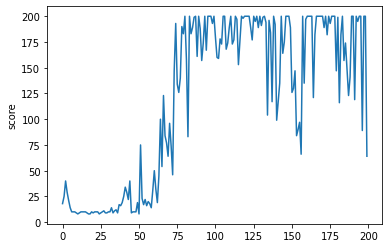

In [ ]:
import gym 
import random 
import math 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

 
#Hyper Parameter
episodes = 200   
gamma = 0.82  
learning_rate = 0.000691      
batch_size = 32  

class DQN:

    def __init__(self):
        self.n=0
        self.model = nn.Sequential(
            nn.Linear(4, 128), # weight 개수: 4*128
            nn.ReLU(), 
            nn.Linear(128, 2)
        )
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate)
        self.steps_done = 0 
        self.memory = deque(maxlen=10000)


    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            action,
                            torch.FloatTensor([reward]),
                            torch.FloatTensor([next_state])))

    def sample_action(self, state):
        eps_threshold = max(0.01, 0.08-0.01*(self.steps_done/200))
        self.steps_done += 1

        if random.random() > eps_threshold:
            return self.model(state).data.max(1)[1].unsqueeze(1)
        else:
            return torch.LongTensor([[random.randrange(2)]])

    def train(self):
        if len(self.memory) < batch_size:
          self.n=0
          return self.n

        batch = random.sample(self.memory, batch_size) 
        states, actions, rewards, next_states = zip(*batch)

        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.cat(next_states)

        current_q = self.model(states).gather(1, actions)

        max_next_q = self.model(next_states).detach().max(1)[0]
        expected_q = rewards + (gamma * max_next_q)

        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.n+=1


env = gym.make('CartPole-v0')
agent = DQN()
score_history = [] 

for num_epi in range(1, episodes+1):
    state = env.reset()
    steps = 0

    while True:
        
        state = torch.FloatTensor([state]) 
        action = agent.sample_action(state) 
        next_state, reward, done, _ = env.step(action.item())

        if done:
            reward = -1

        agent.memorize(state, action, reward, next_state) 
        agent.train()

        state = next_state
        steps += 1

        if done:
            print("Eposide:{0} Score: {1}, n:{2}".format(num_epi, steps, agent.n))
            score_history.append(steps) 
            break

plt.plot(score_history)
plt.ylabel('score')
plt.show()

In [ ]:
import pandas as pd
pd.__version__

'1.3.5'